<a href="https://colab.research.google.com/github/mequanent/Bioinformatics-hws/blob/main/hw5_110761504.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HW5: UPGMA** 

In [1]:
!npx degit https://github.com/mequanent/Bioinformatics-hw2 -f

npx: installed 1 in 3.422s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/Bioinformatics-hw2#HEAD


In [89]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

input = "distanceMatrix1.txt"
input = open(input, 'r')
lines = input.readlines()[1:]
input.close()

# Get the matrix in numpy form and then in pandas form
def getD(lines):
  distance = []
  indices = []
  i = 0
  for line in lines:
    line = line.split()
    distance.append(line)
    indices.append(i)
    i += 1
  # numpy and then pandas form of the distance matrix
  distance = np.array(distance).astype(float)
  dist = pd.DataFrame(distance, index = indices, columns = indices)
  # Add additional column to store the combined entities 
  dist['paired'] = [(chr(i+65)) for i in indices] # Column for paired taxas with their corresponding distances
  dist['paired_no_dist'] = [(chr(i+65)) for i in indices] # Without distance for simplified view of combination
  return dist
dist = getD(lines)

In [103]:
def mini(a):
  loc = (0, 0)
  min = np.Inf 
  cols = [col for col in a.columns if col not in ['paired', 'paired_no_dist']]
  for i in cols:
    for j in cols: 
      if i != j:
        if a.loc[i][j] < min:
          min = a.loc[i][j]
          loc = (i, j)  
  return min, loc

In [91]:
def UPGMA():
  newdist = dist.copy()
  while len(newdist) > 1:
    min_dist, loc = mini(newdist)
    half = str(round(min_dist / 2, 3)) # round result to 3 decimal places

    i, j = min(loc), max(loc)
    p1, p2 = newdist.loc[i]['paired'], newdist.loc[j]['paired']
    p11, p22 = newdist.loc[i]['paired_no_dist'], newdist.loc[j]['paired_no_dist']

    dist1 = newdist.loc[i][~newdist.columns.isin(['paired', 'paired_no_dist'])] 
    dist2 = newdist.loc[j][~newdist.columns.isin(['paired', 'paired_no_dist'])]
    average = (dist1 + dist2)  / 2

    pair = "(" + p1 + ':' + half + ", " + p2 + ':' + half + ")"  # form paired string
    pair_no_dist = "(" + p11 +  ", " + p22 + ")" 

    newdist[i] = average # replace column with the average value
    newdist.loc[i] = average # replace row with the average value

    newdist.drop(j, inplace = True)
    newdist.drop(j, inplace = True, axis = 1)
    newdist.loc[i, i] = 0

    newdist.loc[i, 'paired'] = pair
    newdist.loc[i, 'paired_no_dist'] = pair_no_dist
    #print(newdist)
    #print('*************************************')
  return newdist['paired'][0], newdist['paired_no_dist'][0]
print('With distance:')
print(UPGMA()[0])
print('Without distance:')
print(UPGMA()[1])

With distance:
(A:0.838, (B:0.747, (C:0.326, (D:0.238, (E:0.164, (F:0.135, G:0.135):0.164):0.238):0.326):0.747):0.838)
Without distance:
(A, (B, (C, (D, (E, (F, G))))))


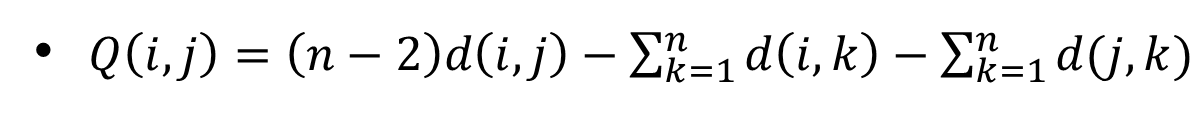

In [92]:
# Get the sum of all distances for each taxa 
def getsum(d): 
  cols = [col for col in d.index]
  sums = dict()
  for i in cols:
    sums[i] = sum(d.loc[i][~d.columns.isin(['paired', 'paired_no_dist'])])    
  return sums

In [129]:
# Calculate Q for the a distance matrix
def getQ(D):
  n = len(D) 
  Q = D.copy()

  cols = [col for col in D.columns if col not in ['paired', 'paired_no_dist']]
  for i in cols:
    for j in cols:  
      if i != j:  
        #dist1 = D.loc[i][~D.columns.isin(['paired', 'paired_no_dist'])] 
        #dist2 = D.loc[j][~D.columns.isin(['paired', 'paired_no_dist'])]

        #dist1 = getsum(D)[i]
        #dist2 = getsum(D)[j]
        dif = getsum(D)[i] + getsum(D)[j]
        Q.loc[i, j] = round(((n-2) * D.loc[i][j] - dif), 3)
        Q.loc[j, i] = Q.loc[i, j]
  return Q    
#getQ(dist)

In [130]:
# How about the value of n? Is it the same for all iterations?
def NJ():
  newdist = getD(lines)
  #n = len(newdist)
  while len(newdist) > 1:
    n = len(newdist)
    q = getQ(newdist)
    min_dist, loc = mini(q)
    f, g = min(loc), max(loc)

    p1, p2 = newdist.loc[f]['paired'], newdist.loc[g]['paired']
    p11, p22 = newdist.loc[f]['paired_no_dist'], newdist.loc[g]['paired_no_dist']

    dist1 = getsum(newdist)[f]
    dist2 = getsum(newdist)[g]
    if len(newdist) > 2:
      dif = (dist1 - dist2) / (n-2)
      delta_fu = round((0.5 * (newdist.loc[f][g] + dif)), 2)
      delta_gu = round((newdist.loc[f][g] - delta_fu), 2)
    else:
      dif = dist1
      delta_fu = round((0.5 * (newdist.loc[f][g] + dif)), 2)
      delta_gu = delta_fu

    pair = "(" + p2 + ':' + str(delta_gu) + ", " + p1 + ':' + str(delta_fu) + ")"  # form paired string
    pair_no_dist = "(" + p22 +  ", " + p11 + ")" 

    tmp = newdist.copy()
    newdist.drop(g, inplace = True) # Remove one row considering f as u
    newdist.drop(g, inplace = True, axis = 1) # Remove one column
    
    cols = [col for col in newdist.columns if col not in [f, 'paired', 'paired_no_dist']]
    for k in cols:    
      newdist.loc[f, k] = round((0.5 * (tmp.loc[f, k] + tmp.loc[g, k] - tmp.loc[f, g])), 3)
      newdist.loc[k, f] = newdist.loc[f, k]    # Column 

    newdist.loc[f, 'paired'] = pair
    newdist.loc[f, 'paired_no_dist'] = pair_no_dist
  return newdist['paired'][0], newdist['paired_no_dist'][0]
print('With distance:')
print(NJ(dist)[0])
print('Without distance:')
print(NJ(dist)[1])

With distance:
((G:0.12, F:0.15):0.04, (E:0.15, (D:0.28, (C:0.36, (B:0.77, A:0.92):0.42):0.05):0.03):0.04)
Without distance:
((G, F), (E, (D, (C, (B, A)))))


In [131]:
method = 'UPGMA'
tree = []
if method == 'UPGMA':
  tree = UPGMA()
elif method == 'NJ':
  tree = NJ()
print(tree[0])

(A:0.838, (B:0.747, (C:0.326, (D:0.238, (E:0.164, (F:0.135, G:0.135):0.164):0.238):0.326):0.747):0.838)


**Manual verification using the example on the slide**

In [117]:
d = ['0 5 9 9 8\n', '5 0 10 10 9\n', '9 10 0 8 7\n', '9 10 8 0 3\n', '8 9 7 3 0\n']
dn = getD(lines)
newdist = dn.copy()
def nja():
  n = len(newdist)
  q = getQ(newdist)
  min_dist, loc = mini(q)
  f, g = min(loc), max(loc)
  
  print(loc)

  p1, p2 = newdist.loc[f]['paired'], newdist.loc[g]['paired']
  p11, p22 = newdist.loc[f]['paired_no_dist'], newdist.loc[g]['paired_no_dist']

  dist1 = getsum(newdist)[f]
  dist2 = getsum(newdist)[g]
  if len(newdist) > 2:
    dif = (dist1 - dist2) / (n-2)
    delta_fu = round((0.5 * (newdist.loc[f][g] + dif)), 2)
    delta_gu = round((newdist.loc[f][g] - delta_fu), 2)
  else:
    dif = dist1
    delta_fu = round((0.5 * (newdist.loc[f][g] + dif)), 2)
    delta_gu = delta_fu

  pair = "(" + p1 + ':' + str(delta_fu) + ", " + p2 + ':' + str(delta_gu) + ")"  # form paired string
  pair_no_dist = "(" + p22 +  ", " + p11 + ")" 

  tmp = newdist.copy()
  
  newdist.drop(g, inplace = True) # Remove one row considering f as u
  newdist.drop(g, inplace = True, axis = 1) # Remove one column
  
  cols = [col for col in newdist.columns if col not in [f, 'paired', 'paired_no_dist']]
  for k in cols:
    newdist.loc[f, k] = round((0.5 * (tmp.loc[f, k] + tmp.loc[g, k] - tmp.loc[f, g])), 3)
    newdist.loc[k, f] = newdist.loc[f, k]    # Column 
      
  newdist.loc[f, 'paired'] = pair
  newdist.loc[f, 'paired_no_dist'] = pair_no_dist
  return newdist
nja() # 1

(0, 1)


,0,2,3,4,5,6,paired,paired_no_dist
0,0.000,0.7780,0.7290,0.6420,0.6780,0.6830,"(A:0.92, B:0.77)","(B, A)"
2,0.778,0.0000,0.7115,0.5958,0.6179,0.5583,C,C
3,0.729,0.7115,0.0000,0.4631,0.5061,0.4710,D,D
4,0.642,0.5958,0.4631,0.0000,0.3484,0.3083,E,E
5,0.678,0.6179,0.5061,0.3484,0.0000,0.2692,F,F
6,0.683,0.5583,0.4710,0.3083,0.2692,0.0000,G,G


In [118]:
getQ(newdist)

,0,2,3,4,5,6,paired,paired_no_dist
0,0.000,-3.659,-3.475,-3.300,-3.218,-3.068,"(A:0.92, B:0.77)","(B, A)"
2,-3.659,0.000,-3.296,-3.236,-3.210,-3.318,C,C
3,-3.475,-3.296,0.000,-3.386,-3.276,-3.287,D,D
4,-3.300,-3.236,-3.386,0.000,-3.384,-3.414,E,E
5,-3.218,-3.210,-3.276,-3.384,0.000,-3.633,F,F
6,-3.068,-3.318,-3.287,-3.414,-3.633,0.000,G,G


In [119]:
nja() # 2

(0, 2)


,0,3,4,5,6,paired,paired_no_dist
0,0.000,0.3310,0.2300,0.2590,0.2320,"((A:0.92, B:0.77):0.42, C:0.36)","(C, (B, A))"
3,0.331,0.0000,0.4631,0.5061,0.4710,D,D
4,0.230,0.4631,0.0000,0.3484,0.3083,E,E
5,0.259,0.5061,0.3484,0.0000,0.2692,F,F
6,0.232,0.4710,0.3083,0.2692,0.0000,G,G


In [120]:
getQ(newdist)

,0,3,4,5,6,paired,paired_no_dist
0,0.000,-1.830,-1.712,-1.658,-1.636,"((A:0.92, B:0.77):0.42, C:0.36)","(C, (B, A))"
3,-1.830,0.000,-1.732,-1.636,-1.639,D,D
4,-1.712,-1.732,0.000,-1.687,-1.705,E,E
5,-1.658,-1.636,-1.687,0.000,-1.856,F,F
6,-1.636,-1.639,-1.705,-1.856,0.000,G,G


In [121]:
nja() # 3 ((G, F), (D, (C, (B, A))), E)

(5, 6)


,0,3,4,5,paired,paired_no_dist
0,0.000,0.3310,0.2300,0.111,"((A:0.92, B:0.77):0.42, C:0.36)","(C, (B, A))"
3,0.331,0.0000,0.4631,0.354,D,D
4,0.230,0.4631,0.0000,0.194,E,E
5,0.111,0.3540,0.1940,0.000,"(F:0.15, G:0.12)","(G, F)"


In [122]:
getQ(newdist)

,0,3,4,5,paired,paired_no_dist
0,0.000,-1.158,-1.099,-1.109,"((A:0.92, B:0.77):0.42, C:0.36)","(C, (B, A))"
3,-1.158,0.000,-1.109,-1.099,D,D
4,-1.099,-1.109,0.000,-1.158,E,E
5,-1.109,-1.099,-1.158,0.000,"(F:0.15, G:0.12)","(G, F)"


In [123]:
nja() # 4

(0, 3)


,0,4,5,paired,paired_no_dist
0,0.000,0.181,0.067,"(((A:0.92, B:0.77):0.42, C:0.36):0.05, D:0.28)","(D, (C, (B, A)))"
4,0.181,0.000,0.194,E,E
5,0.067,0.194,0.000,"(F:0.15, G:0.12)","(G, F)"


In [124]:
getQ(newdist)

,0,4,5,paired,paired_no_dist
0,0.000,-0.442,-0.442,"(((A:0.92, B:0.77):0.42, C:0.36):0.05, D:0.28)","(D, (C, (B, A)))"
4,-0.442,0.000,-0.442,E,E
5,-0.442,-0.442,0.000,"(F:0.15, G:0.12)","(G, F)"


In [125]:
nja() # 5 

(0, 4)


,0,5,paired,paired_no_dist
0,0.00,0.04,"((((A:0.92, B:0.77):0.42, C:0.36):0.05, D:0.28):0.03, E:0.15)","(E, (D, (C, (B, A))))"
5,0.04,0.00,"(F:0.15, G:0.12)","(G, F)"


In [126]:
nja() # 6

(0, 5)


,0,paired,paired_no_dist
0,0.0,"(((((A:0.92, B:0.77):0.42, C:0.36):0.05, D:0.28):0.03, E:0.15):0.04, (F:0.15, G:0.12):0.04)","((G, F), (E, (D, (C, (B, A)))))"


In [ ]:
((G, F), (D, (C, (B, A))), E)

In [ ]:
((G, F), (D, (C, (B, A))), E)

In [ ]:
((G:0.12, F:0.15):0.04, (D:0.28, (C:0.36, (B:0.77, A:0.92):0.42):0.05):0.03, E:0.15);

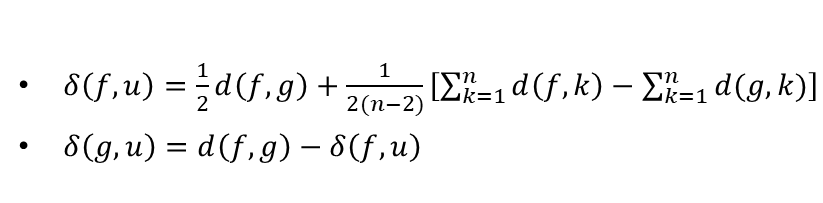

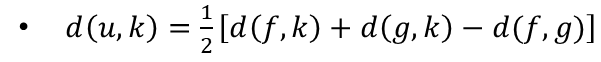

In [ ]:
Q = getQ()
len(Q) - 2

5

In [ ]:
~Q.index.isin(['paired', 'paired_no_dist'])]

In [ ]:
mini(getQ())

(-10.395299999999999, (1, 0))

In [ ]:
sum(dist2)


4.7848

In [ ]:
dist1 = dist.loc[5][~dist.columns.isin(['paired', 'paired_no_dist'])] 
dist2 = dist.loc[6][~dist.columns.isin(['paired', 'paired_no_dist'])]
dif = sum(dist1) - sum(dist2)

In [ ]:
# Get off diagonal part
def offdiagonal(a):
  offdiag = []
  for i in range(1, a.shape[0]):
    row = []
    for j in range(i):
      row.append(a[i][j])
    offdiag.append(row)
  return offdiag
offdiagonal(distance)

[[1.6866],
 [1.7198, 1.5232],
 [1.6606, 1.4841, 0.7115],
 [1.5243, 1.4465, 0.5958, 0.4631],
 [1.6043, 1.4389, 0.6179, 0.5061, 0.3484],
 [1.5905, 1.4629, 0.5583, 0.471, 0.3083, 0.2692]]